## **Теория по YOLOv8**:



---



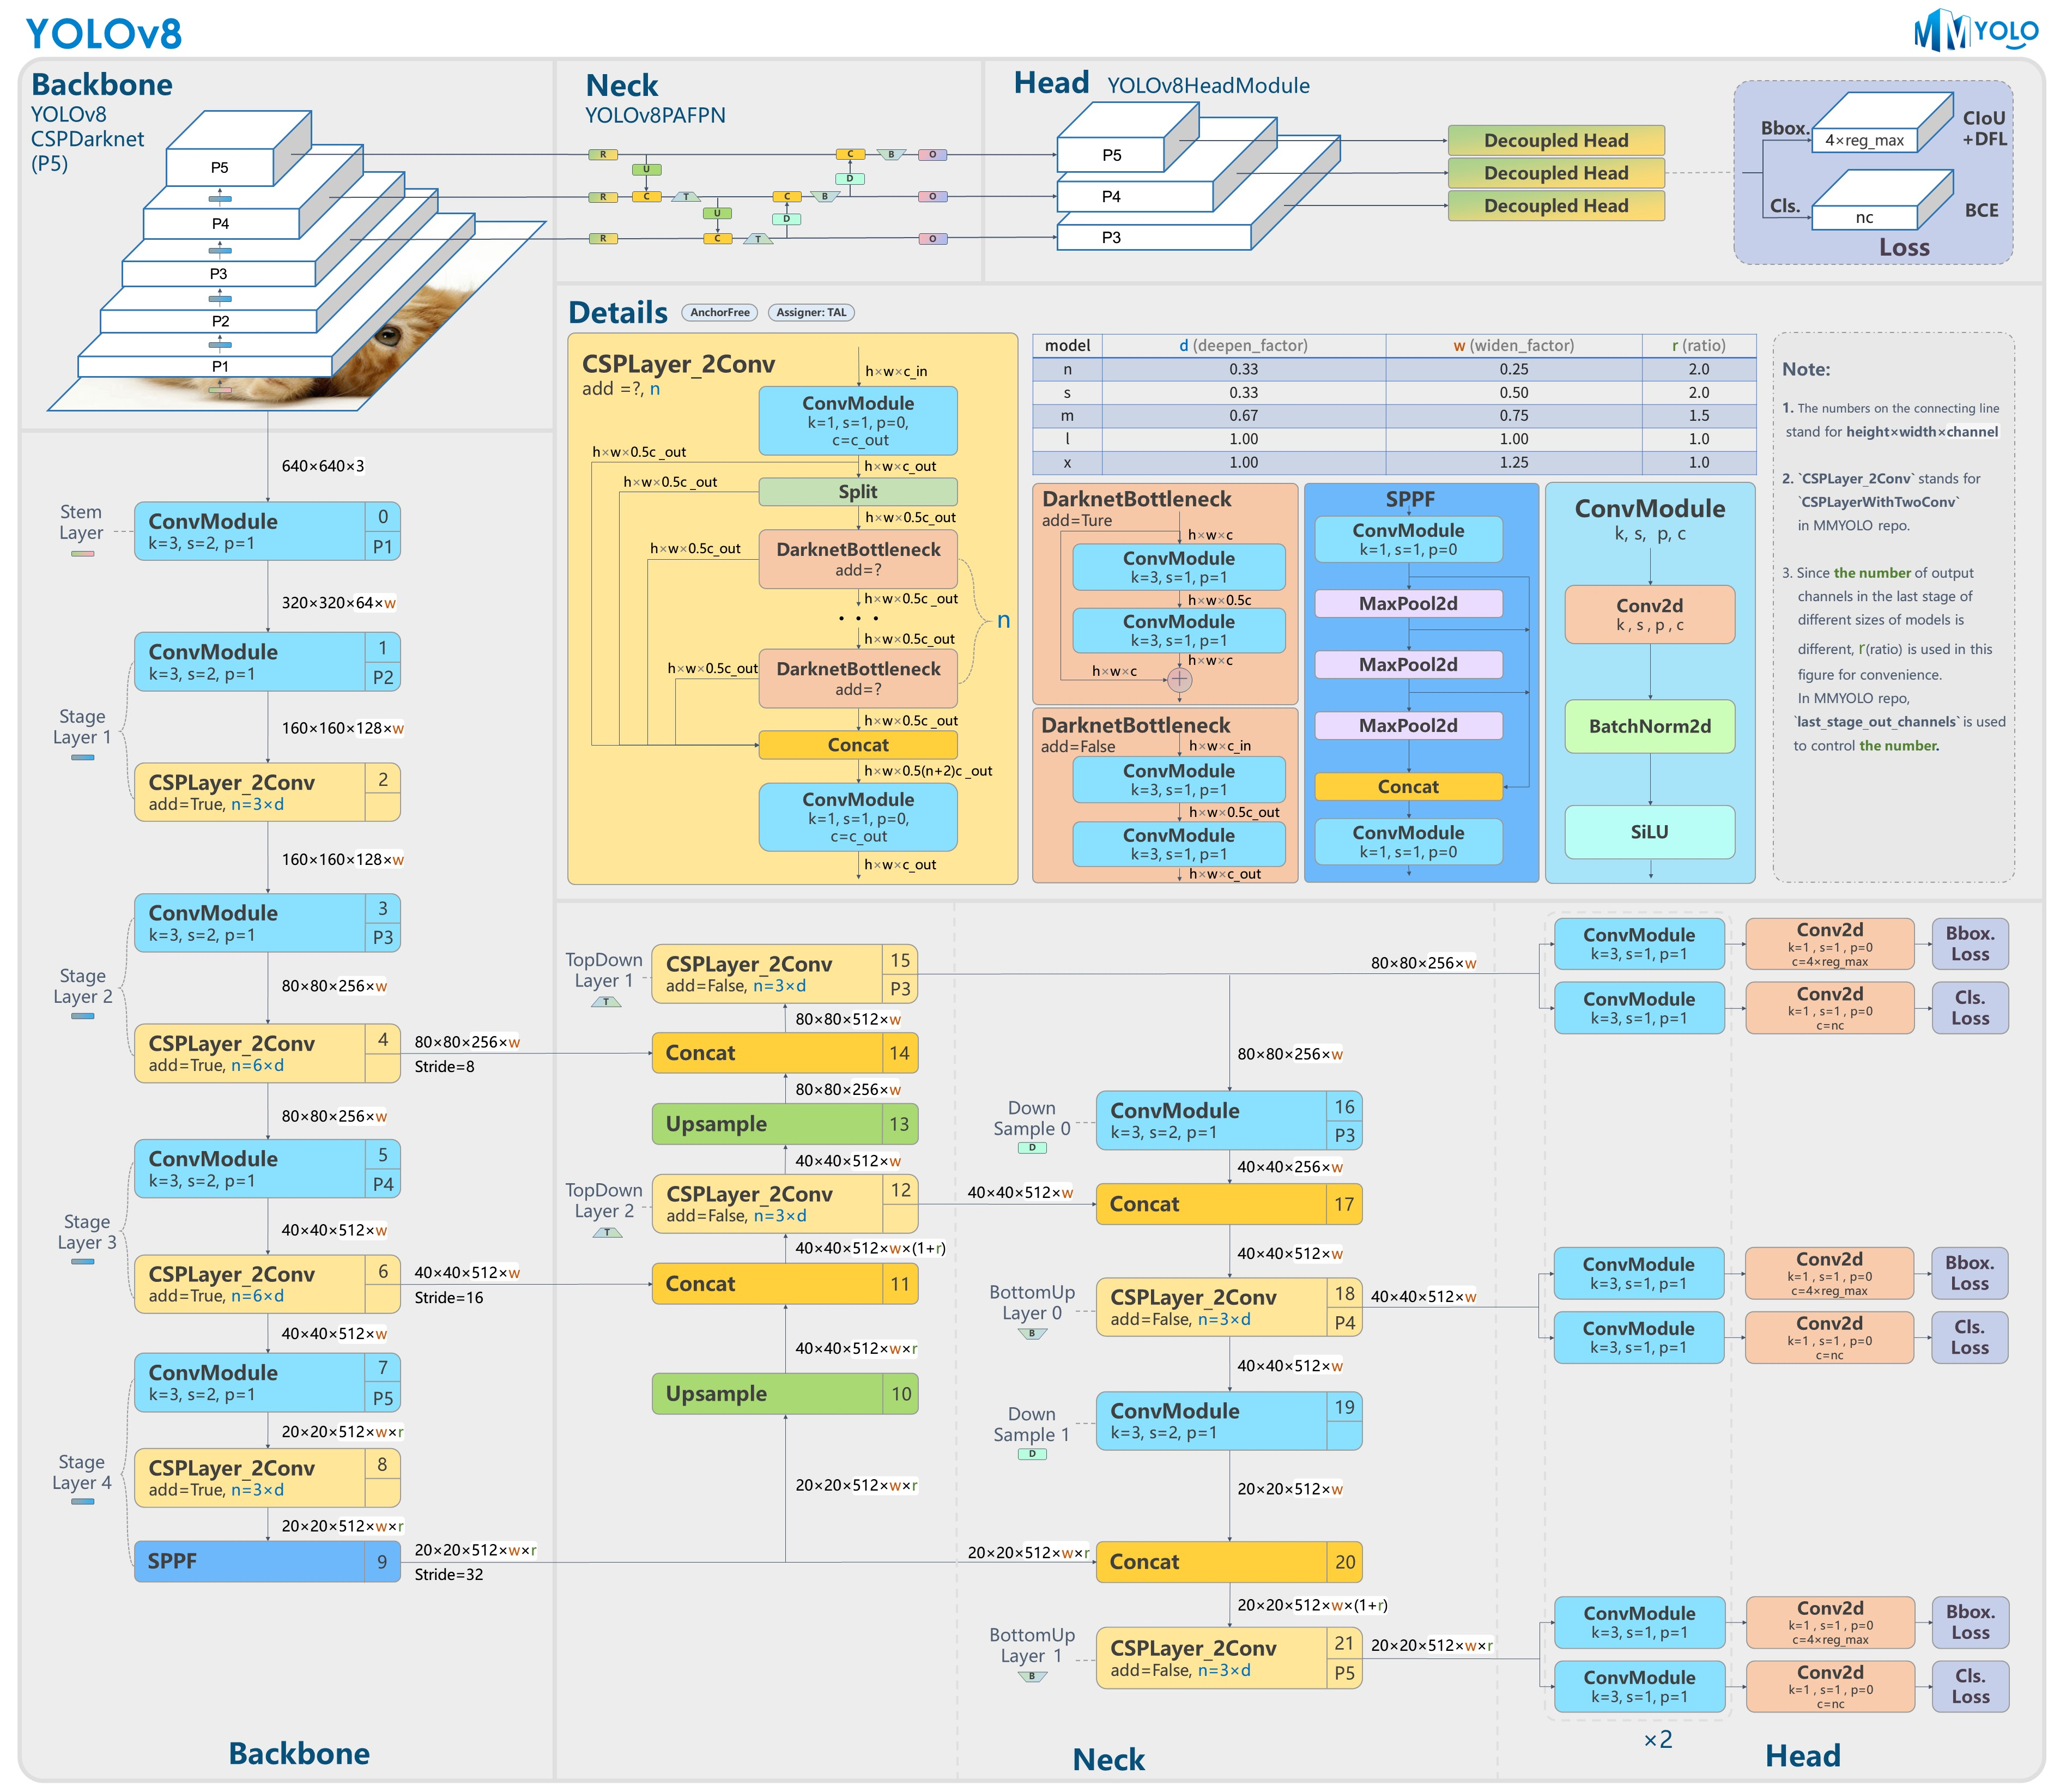

##  YOLOv8: Теоретический Обзор Архитектуры

YOLOv8 состоит из трёх основных компонентов: **Backbone, Neck, Head**.

###  Backbone
- Отвечает за извлечение признаков из изображения.
- Использует **C2f-блоки** (Cross Stage Partial with Fusion) — ускоренная версия CSPLayer.
- Базовая структура: `Conv2d → BatchNorm → SiLU`.
- В конце находится **SPPF-блок** (Spatial Pyramid Pooling - Fast) для увеличения зоны восприятия признаков.

###  Neck
- Использует **Feature Pyramid Network (FPN)** и **Path Aggregation Network (PAN)**.
- Объединяет признаки с разных уровней (мелкие, средние, крупные).
- Основные операции:
  - `Upsample`: увеличивает разрешение фичей,
  - `Concat`: объединяет признаки из разных уровней,
  - `Conv`: обрабатывает объединённые фичи.

###  Head
- Anchor-Free: предсказывает координаты напрямую.
- Делает предсказания на трёх масштабах.
- Каждый выходной вектор содержит:
  - `x, y, w, h` — координаты бокса,
  - `objectness` — вероятность, что в боксе есть объект,
  - `class scores` — вероятности классов.

###  Базовые строительные блоки
- **ConvModule**: `Conv2d → BatchNorm → SiLU`
- **DarknetBottleneck**: residual-блок с Conv1x1 и Conv3x3
- **SPPF**: объединяет признаки с помощью MaxPool с ядрами 5×5, 9×9, 13×13

 YOLOv8 легче, быстрее и точнее, чем предыдущие версии (YOLOv5/YOLOv7).

 ---


## Создание датасета в GoogleDrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os
import shutil

images_dir = '/content/drive/MyDrive/Colab/validation/image'
jsons_dir = '/content/drive/MyDrive/Colab/validation/annos'
filtered_dir = '/content/drive/MyDrive/Colab/validation/filtered_images'

os.makedirs(filtered_dir, exist_ok=True)

json_files = [os.path.splitext(f)[0] for f in os.listdir(jsons_dir) if f.endswith('.json')]
print(f"Найдено {len(json_files)} разметок")

count_copied = 0
for fname in json_files:
    image_name = fname + '.jpg'
    image_path = os.path.join(images_dir, image_name)
    if os.path.exists(image_path):
        shutil.copy(image_path, os.path.join(filtered_dir, image_name))
        count_copied += 1

print(f"Скопировано {count_copied} изображений в {filtered_dir}")


Найдено 11668 разметок
Скопировано 11335 изображений в /content/drive/MyDrive/Colab/validation/filtered_images


## Подготовка правильного формата для YOLO. Из Json в txt с координатами одежды

In [ ]:
import os
import json
from PIL import Image

json_dir = '/content/drive/MyDrive/Colab/validation/annos'
image_dir = '/content/drive/MyDrive/Colab/validation/filtered_images'
label_dir = '/content/drive/MyDrive/Colab/validation/labels'
os.makedirs(label_dir, exist_ok=True)

for json_file in os.listdir(json_dir):
    if not json_file.endswith('.json'):
        continue

    json_path = os.path.join(json_dir, json_file)
    image_name = os.path.splitext(json_file)[0] + '.jpg'
    image_path = os.path.join(image_dir, image_name)

    if not os.path.exists(image_path):
        continue

    with Image.open(image_path) as img:
        img_w, img_h = img.size

    with open(json_path, 'r') as f:
        data = json.load(f)

    yolo_lines = []
    for item_key in data:
        if not item_key.startswith('item'):
            continue
        item = data[item_key]

        try:
            bbox = item['bounding_box']
            cls_id = item['category_id'] -1
        except KeyError:
            continue

        x_min, y_min, x_max, y_max = bbox
        x_center = ((x_min + x_max) / 2) / img_w
        y_center = ((y_min + y_max) / 2) / img_h
        width = (x_max - x_min) / img_w
        height = (y_max - y_min) / img_h

        yolo_line = f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
        yolo_lines.append(yolo_line)

    label_path = os.path.join(label_dir, os.path.splitext(json_file)[0] + '.txt')
    with open(label_path, 'w') as f:
        f.write('\n'.join(yolo_lines))

print(f"Конвертация завершена. Разметка сохранена в: {label_dir}")


Конвертация завершена. Разметка сохранена в: /content/drive/MyDrive/Colab/validation/labels


## Разделение датасета на train и val

In [ ]:
import os
import random
import shutil


images_dir = '/content/drive/MyDrive/Colab/validation/filtered_images'
labels_dir = '/content/drive/MyDrive/Colab/validation/labels'
output_base = '/content/drive/MyDrive/Colab/dataset_yolo'

for split in ['train', 'val']:
    os.makedirs(os.path.join(output_base, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_base, split, 'labels'), exist_ok=True)


all_labels = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]
random.shuffle(all_labels)

train_labels = all_labels[:9000]
val_labels = all_labels[9000:11000]

def copy_split(labels_list, split):
    for label_file in labels_list:
        image_file = label_file.replace('.txt', '.jpg')
        src_img = os.path.join(images_dir, image_file)
        src_lbl = os.path.join(labels_dir, label_file)

        dst_img = os.path.join(output_base, split, 'images', image_file)
        dst_lbl = os.path.join(output_base, split, 'labels', label_file)

        if os.path.exists(src_img):
            shutil.copy(src_img, dst_img)
        shutil.copy(src_lbl, dst_lbl)

copy_split(train_labels, 'train')
copy_split(val_labels, 'val')

print("Разделение завершено.")


Разделение завершено.


## Создание файла data.yamal для обучения YOLO. Пути до датасета и название определяемых классов

In [ ]:
yaml_rus = """path: /content/drive/MyDrive/Colab/dataset_yolo
train: train/images
val: val/images
names:
  0: футболка с коротким рукавом
  1: футболка с длинным рукавом
  2: верхняя одежда с коротким рукавом
  3: верхняя одежда с длинным рукавом
  4: жилет
  5: платье с бретельками
  6: шорты
  7: брюки
  8: юбка
  9: платье с коротким рукавом
  10: платье с длинным рукавом
  11: платье-жилет
  12: длинное платье-жилет
"""

with open("/content/drive/MyDrive/Colab/dataset_yolo/data.yaml", "w") as f:
    f.write(yaml_rus)


## Распределение по классам для обучения YOLO

In [ ]:
import os
import json
from collections import defaultdict

json_dir = '/content/drive/MyDrive/Colab/validation/annos'
category_to_count = defaultdict(int)

for file in os.listdir(json_dir):
    if not file.endswith('.json'):
        continue
    with open(os.path.join(json_dir, file), 'r') as f:
        data = json.load(f)
        for key, item in data.items():
            if key.startswith('item') and 'category_id' in item:
                category_to_count[item['category_id']] += 1

for cat_id in sorted(category_to_count):
    print(f"Category ID: {cat_id}, Count: {category_to_count[cat_id]}")


Category ID: 1, Count: 4558
Category ID: 2, Count: 2239
Category ID: 3, Count: 63
Category ID: 4, Count: 762
Category ID: 5, Count: 732
Category ID: 6, Count: 117
Category ID: 7, Count: 1506
Category ID: 8, Count: 3492
Category ID: 9, Count: 2381
Category ID: 10, Count: 1107
Category ID: 11, Count: 491
Category ID: 12, Count: 1225
Category ID: 13, Count: 420


## Обучение предобученной модели YOLOv8 для обнаружения одежды на фото

In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')  # можно заменить на yolov8s.pt или yolov8m.pt

model.train(
    data='/content/drive/MyDrive/dataset_yolo/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    name='deepfashion_yolo',
    patience=10,         # ранняя остановка
    project='/content/drive/MyDrive/Colab/runs',
    augment=True,        # включает аугментации
    mosaic=1.0,          # mosaics augmentation
    hsv_h=0.015, hsv_s=0.4, hsv_v=0.3,  # цветовые аугментации
    flipud=0.1, fliplr=0.5,  # флипы
    degrees=10.0,        # повороты
    scale=0.3,
    shear=0.5,
    perspective=0.0005,
    lr0=0.01,            # начальная скорость обучения
    weight_decay=0.0005, # регуляризация
    warmup_epochs=3,
)


Ultralytics 8.3.153 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab/dataset_yolo/data.yaml, degrees=10.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4, hsv_v=0.3, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=deepfashion_yolo3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0005, 

train: Scanning /content/drive/MyDrive/Colab/dataset_yolo/train/labels.cache... 10850 images, 0 backgrounds, 57 corrupt: 100%|██████████| 10850/10850 [00:00<?, ?it/s]

train: /content/drive/MyDrive/Colab/dataset_yolo/train/images/000216.jpg: ignoring corrupt image/label: Label class 13 exceeds dataset class count 13. Possible class labels are 0-12
train: /content/drive/MyDrive/Colab/dataset_yolo/train/images/000723.jpg: ignoring corrupt image/label: Label class 13 exceeds dataset class count 13. Possible class labels are 0-12
train: /content/drive/MyDrive/Colab/dataset_yolo/train/images/000807.jpg: ignoring corrupt image/label: Label class 13 exceeds dataset class count 13. Possible class labels are 0-12
train: /content/drive/MyDrive/Colab/dataset_yolo/train/images/001294.jpg: ignoring corrupt image/label: Label class 13 exceeds dataset class count 13. Possible class labels are 0-12
train: /content/drive/MyDrive/Colab/dataset_yolo/train/images/001719.jpg: ignoring corrupt image/label: Label class 13 exceeds dataset class count 13. Possible class labels are 0-12
train: /content/drive/MyDrive/Colab/dataset_yolo/train/images/001722.jpg: ignoring corrupt

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.2±0.3 ms, read: 14.0±5.7 MB/s, size: 54.1 KB)


val: Scanning /content/drive/MyDrive/Colab/dataset_yolo/val/labels.cache... 3662 images, 0 backgrounds, 57 corrupt: 100%|██████████| 3662/3662 [00:00<?, ?it/s]

val: /content/drive/MyDrive/Colab/dataset_yolo/val/images/000001.jpg: ignoring corrupt image/label: Label class 13 exceeds dataset class count 13. Possible class labels are 0-12
val: /content/drive/MyDrive/Colab/dataset_yolo/val/images/000722.jpg: ignoring corrupt image/label: Label class 13 exceeds dataset class count 13. Possible class labels are 0-12
val: /content/drive/MyDrive/Colab/dataset_yolo/val/images/000840.jpg: ignoring corrupt image/label: Label class 13 exceeds dataset class count 13. Possible class labels are 0-12
val: /content/drive/MyDrive/Colab/dataset_yolo/val/images/001688.jpg: ignoring corrupt image/label: Label class 13 exceeds dataset class count 13. Possible class labels are 0-12
val: /content/drive/MyDrive/Colab/dataset_yolo/val/images/001796.jpg: ignoring corrupt image/label: Label class 13 exceeds dataset class count 13. Possible class labels are 0-12
val: /content/drive/MyDrive/Colab/dataset_yolo/val/images/001797.jpg: ignoring corrupt image/label: Label clas

Plotting labels to /content/drive/MyDrive/Colab/runs/deepfashion_yolo3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/drive/MyDrive/Colab/runs/deepfashion_yolo3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.768      4.313       2.19         69        640:   0%|          | 1/675 [01:54<21:29:14, 114.77s/it]

## Создание нового датасета для обучения модели классификации на 7 новых классов

In [ ]:
from ultralytics import YOLO
import cv2
import os
from tqdm import tqdm


images_dir = '/content/drive/MyDrive/dataset_yolo/train/images'
output_dir = '/content/drive/MyDrive/dataset_yolo/crops'
os.makedirs(output_dir, exist_ok=True)

model = YOLO('/content/drive/MyDrive/Colab/runs/deepfashion_yolo7/weights/best.pt')

class_map = {
    0: 0,  # футболка
    1: 0,  # футболка
    2: 1,  # верхняя одежда
    3: 1,  # верхняя одежда
    4: 2,  # жилет
    5: 3,  # платье с бретельками
    6: 4,  # шорты
    7: 5,  # брюки
    8: 6,  # юбка
    9: 3,  # платье с коротким рукавом
    10: 3, # платье с длинным рукавом
    11: 3, # платье-жилет
    12: 3  # длинное платье-жилет
}

image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

for img_name in tqdm(image_files, desc='Обработка изображений'):
    img_path = os.path.join(images_dir, img_name)
    results = model(img_path, conf=0.25, imgsz=640)

    img = cv2.imread(img_path)

    for i, r in enumerate(results):
        boxes = r.boxes
        for j, box in enumerate(boxes):
            xyxy = box.xyxy[0].cpu().numpy().astype(int)
            cls = int(box.cls[0])
            conf = float(box.conf[0])

            new_cls = class_map.get(cls, -1)
            if new_cls == -1:
                continue

            x1, y1, x2, y2 = xyxy
            crop = img[y1:y2, x1:x2]

            crop_filename = f"{os.path.splitext(img_name)[0]}_cls{new_cls}_conf{conf:.2f}_{j}.jpg"
            crop_path = os.path.join(output_dir, crop_filename)

            cv2.imwrite(crop_path, crop)

## График распределения классов

Распределение по классам:
Класс 0: 3972 изображений
Класс 5: 2068 изображений
Класс 3: 1660 изображений
Класс 6: 1319 изображений
Класс 4: 766 изображений
Класс 1: 421 изображений
Класс 2: 420 изображений


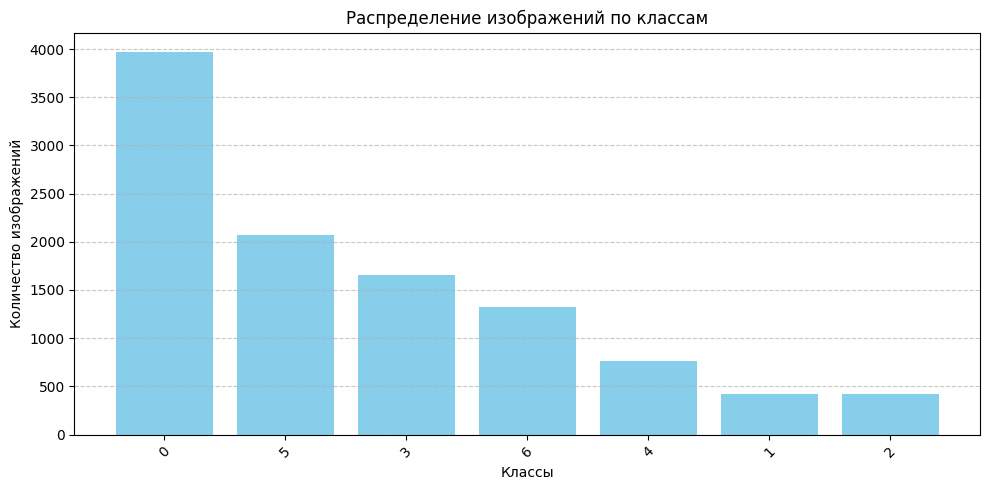

In [ ]:
import os
import matplotlib.pyplot as plt

sorted_dir = '/content/drive/MyDrive/Colab/dataset_yolo/classifier_dataset/train'

class_counts = {}

for class_name in os.listdir(sorted_dir):
    class_path = os.path.join(sorted_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        class_counts[class_name] = num_images

class_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))

print("Распределение по классам:")
for cls, count in class_counts.items():
    print(f"Класс {cls}: {count} изображений")

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Классы")
plt.ylabel("Количество изображений")
plt.title("Распределение изображений по классам")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Обучение модели классификаци на датасете из кропов: classifier_dataset. При помощи предобученной модели ResNet18.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
import os
import numpy as np
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class Config:
    BATCH_SIZE = 64
    EPOCHS = 30
    NUM_CLASSES = 7
    IMAGE_SIZE = 224
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    LR = 3e-4
    EARLY_STOP_PATIENCE = 7
    CLASS_COUNTS = [3972, 421, 420, 1660, 766, 2068, 1319]  # Ваши данные
    SAVE_PATH = "/content/drive/MyDrive/models/best_clothing_model.pth"


    CLASS_WEIGHTS = [0.15, 0.12, 0.12, 0.18, 0.15, 0.16, 0.12]  # Сумма=1

class ClothingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        for cls in os.listdir(root_dir):
            cls_dir = os.path.join(root_dir, cls)
            if os.path.isdir(cls_dir):
                for file in os.listdir(cls_dir):
                    if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                        self.samples.append((os.path.join(cls_dir, file), int(cls)))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except:
            return torch.zeros(3, Config.IMAGE_SIZE, Config.IMAGE_SIZE), label

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(Config.IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(Config.IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class ClothingModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        for param in self.base.parameters():
            param.requires_grad = False

        in_features = self.base.fc.in_features
        self.base.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.base(x)

def train_model():
    # Инициализация
    model = ClothingModel(Config.NUM_CLASSES).to(Config.DEVICE)
    criterion = nn.CrossEntropyLoss(
        weight=torch.tensor(Config.CLASS_WEIGHTS).to(Config.DEVICE)
    )
    optimizer = optim.Adam(model.parameters(), lr=Config.LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

    # Данные
    train_dataset = ClothingDataset(
        "/content/drive/MyDrive/Colab/dataset_yolo/classifier_dataset/train",
        train_transform
    )
    val_dataset = ClothingDataset(
        "/content/drive/MyDrive/Colab/dataset_yolo/classifier_dataset/val",
        val_transform
    )

    sample_weights = [Config.CLASS_WEIGHTS[label] for _, label in train_dataset.samples]
    sampler = WeightedRandomSampler(sample_weights, len(train_dataset), replacement=True)

    train_loader = DataLoader(
        train_dataset, batch_size=Config.BATCH_SIZE,
        sampler=sampler, num_workers=2
    )
    val_loader = DataLoader(
        val_dataset, batch_size=Config.BATCH_SIZE,
        shuffle=False, num_workers=2
    )

    # Обучение
    best_f1 = 0
    no_improve = 0

    for epoch in range(Config.EPOCHS):
        model.train()
        train_loss = 0
        progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS}")

        for inputs, labels in progress:
            inputs, labels = inputs.to(Config.DEVICE), labels.to(Config.DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            progress.set_postfix(loss=train_loss/(progress.n+1))

        # Валидация
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(Config.DEVICE), labels.to(Config.DEVICE)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Метрики
        current_f1 = f1_score(all_labels, all_preds, average='weighted')
        scheduler.step(current_f1)

        print(f"\nEpoch {epoch+1} Results:")
        print(classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(Config.NUM_CLASSES)]))

        if current_f1 > best_f1 + 0.005:  # Значимое улучшение
            best_f1 = current_f1
            no_improve = 0
            torch.save({
                'epoch': epoch,
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'f1': best_f1,
                'report': classification_report(all_labels, all_preds, output_dict=True)
            }, Config.SAVE_PATH)
            print(f"Saved best model (F1: {best_f1:.4f})")
        else:
            no_improve += 1
            if no_improve >= Config.EARLY_STOP_PATIENCE:
                print(f"Early stopping at epoch {epoch+1}")
                break

if __name__ == "__main__":
    print(" Configuration:")
    print(f"Device: {Config.DEVICE}")
    print(f"Classes: {Config.NUM_CLASSES}")
    print(f"Class weights: {Config.CLASS_WEIGHTS}")

    train_model()
    print(f"\nTraining complete! Best model saved to {Config.SAVE_PATH}")

⚙️ Configuration:
Device: cuda
Classes: 7
Class weights: [0.15, 0.12, 0.12, 0.18, 0.15, 0.16, 0.12]


Epoch 1/30: 100%|██████████| 167/167 [01:28<00:00,  1.88it/s, loss=1.16]



Epoch 1 Results:
              precision    recall  f1-score   support

     Class 0       0.64      0.89      0.74       993
     Class 1       1.00      0.06      0.11       106
     Class 2       0.00      0.00      0.00       106
     Class 3       0.58      0.61      0.59       415
     Class 4       0.57      0.30      0.39       192
     Class 5       0.62      0.76      0.68       518
     Class 6       0.74      0.20      0.32       330

    accuracy                           0.63      2660
   macro avg       0.59      0.40      0.41      2660
weighted avg       0.62      0.63      0.58      2660

💾 Saved best model (F1: 0.5753)


Epoch 2/30: 100%|██████████| 167/167 [01:20<00:00,  2.08it/s, loss=0.939]



Epoch 2 Results:
              precision    recall  f1-score   support

     Class 0       0.74      0.77      0.75       993
     Class 1       0.81      0.12      0.21       106
     Class 2       0.94      0.14      0.25       106
     Class 3       0.51      0.73      0.60       415
     Class 4       0.48      0.42      0.44       192
     Class 5       0.64      0.76      0.69       518
     Class 6       0.62      0.41      0.50       330

    accuracy                           0.64      2660
   macro avg       0.68      0.48      0.49      2660
weighted avg       0.66      0.64      0.62      2660

💾 Saved best model (F1: 0.6218)


Epoch 3/30: 100%|██████████| 167/167 [01:18<00:00,  2.13it/s, loss=0.861]



Epoch 3 Results:
              precision    recall  f1-score   support

     Class 0       0.74      0.83      0.78       993
     Class 1       0.88      0.27      0.42       106
     Class 2       0.82      0.17      0.28       106
     Class 3       0.54      0.74      0.63       415
     Class 4       0.66      0.41      0.50       192
     Class 5       0.66      0.81      0.73       518
     Class 6       0.65      0.33      0.44       330

    accuracy                           0.67      2660
   macro avg       0.71      0.51      0.54      2660
weighted avg       0.69      0.67      0.65      2660

💾 Saved best model (F1: 0.6500)


Epoch 4/30: 100%|██████████| 167/167 [01:19<00:00,  2.09it/s, loss=0.856]



Epoch 4 Results:
              precision    recall  f1-score   support

     Class 0       0.77      0.78      0.78       993
     Class 1       0.80      0.31      0.45       106
     Class 2       0.84      0.20      0.32       106
     Class 3       0.51      0.81      0.63       415
     Class 4       0.74      0.33      0.45       192
     Class 5       0.62      0.84      0.71       518
     Class 6       0.71      0.30      0.42       330

    accuracy                           0.66      2660
   macro avg       0.71      0.51      0.54      2660
weighted avg       0.70      0.66      0.64      2660



Epoch 5/30: 100%|██████████| 167/167 [01:19<00:00,  2.11it/s, loss=0.814]



Epoch 5 Results:
              precision    recall  f1-score   support

     Class 0       0.70      0.86      0.77       993
     Class 1       0.80      0.23      0.35       106
     Class 2       0.72      0.29      0.42       106
     Class 3       0.59      0.67      0.63       415
     Class 4       0.57      0.44      0.50       192
     Class 5       0.68      0.76      0.72       518
     Class 6       0.67      0.35      0.46       330

    accuracy                           0.67      2660
   macro avg       0.68      0.52      0.55      2660
weighted avg       0.67      0.67      0.65      2660



Epoch 6/30: 100%|██████████| 167/167 [01:17<00:00,  2.15it/s, loss=0.798]



Epoch 6 Results:
              precision    recall  f1-score   support

     Class 0       0.78      0.81      0.79       993
     Class 1       0.74      0.29      0.42       106
     Class 2       0.67      0.28      0.40       106
     Class 3       0.58      0.73      0.65       415
     Class 4       0.62      0.40      0.48       192
     Class 5       0.65      0.81      0.72       518
     Class 6       0.59      0.43      0.50       330

    accuracy                           0.68      2660
   macro avg       0.66      0.54      0.57      2660
weighted avg       0.68      0.68      0.67      2660

💾 Saved best model (F1: 0.6667)


Epoch 7/30: 100%|██████████| 167/167 [01:20<00:00,  2.07it/s, loss=0.773]



Epoch 7 Results:
              precision    recall  f1-score   support

     Class 0       0.76      0.80      0.78       993
     Class 1       0.70      0.29      0.41       106
     Class 2       0.72      0.25      0.37       106
     Class 3       0.52      0.77      0.62       415
     Class 4       0.65      0.43      0.51       192
     Class 5       0.65      0.83      0.73       518
     Class 6       0.71      0.30      0.42       330

    accuracy                           0.67      2660
   macro avg       0.67      0.52      0.55      2660
weighted avg       0.68      0.67      0.65      2660



Epoch 8/30: 100%|██████████| 167/167 [01:19<00:00,  2.10it/s, loss=0.77]



Epoch 8 Results:
              precision    recall  f1-score   support

     Class 0       0.72      0.87      0.79       993
     Class 1       0.62      0.31      0.42       106
     Class 2       0.72      0.26      0.39       106
     Class 3       0.55      0.77      0.65       415
     Class 4       0.65      0.42      0.51       192
     Class 5       0.75      0.75      0.75       518
     Class 6       0.70      0.32      0.44       330

    accuracy                           0.68      2660
   macro avg       0.67      0.53      0.56      2660
weighted avg       0.69      0.68      0.66      2660



Epoch 9/30: 100%|██████████| 167/167 [01:19<00:00,  2.10it/s, loss=0.743]



Epoch 9 Results:
              precision    recall  f1-score   support

     Class 0       0.77      0.83      0.80       993
     Class 1       0.82      0.26      0.40       106
     Class 2       0.75      0.25      0.38       106
     Class 3       0.57      0.76      0.65       415
     Class 4       0.67      0.44      0.53       192
     Class 5       0.61      0.85      0.71       518
     Class 6       0.75      0.28      0.40       330

    accuracy                           0.68      2660
   macro avg       0.71      0.52      0.55      2660
weighted avg       0.70      0.68      0.66      2660



Epoch 10/30: 100%|██████████| 167/167 [01:20<00:00,  2.08it/s, loss=0.727]



Epoch 10 Results:
              precision    recall  f1-score   support

     Class 0       0.79      0.78      0.78       993
     Class 1       0.78      0.33      0.46       106
     Class 2       0.80      0.30      0.44       106
     Class 3       0.55      0.79      0.64       415
     Class 4       0.56      0.47      0.51       192
     Class 5       0.67      0.80      0.73       518
     Class 6       0.65      0.42      0.51       330

    accuracy                           0.68      2660
   macro avg       0.68      0.55      0.58      2660
weighted avg       0.69      0.68      0.67      2660



Epoch 11/30: 100%|██████████| 167/167 [01:18<00:00,  2.12it/s, loss=0.705]



Epoch 11 Results:
              precision    recall  f1-score   support

     Class 0       0.75      0.83      0.79       993
     Class 1       0.75      0.31      0.44       106
     Class 2       0.77      0.25      0.38       106
     Class 3       0.56      0.73      0.63       415
     Class 4       0.59      0.43      0.49       192
     Class 5       0.66      0.80      0.72       518
     Class 6       0.70      0.35      0.47       330

    accuracy                           0.68      2660
   macro avg       0.68      0.53      0.56      2660
weighted avg       0.69      0.68      0.66      2660



Epoch 12/30: 100%|██████████| 167/167 [01:20<00:00,  2.08it/s, loss=0.708]



Epoch 12 Results:
              precision    recall  f1-score   support

     Class 0       0.74      0.87      0.80       993
     Class 1       0.79      0.31      0.45       106
     Class 2       0.74      0.35      0.47       106
     Class 3       0.62      0.69      0.66       415
     Class 4       0.65      0.47      0.55       192
     Class 5       0.69      0.81      0.74       518
     Class 6       0.72      0.40      0.52       330

    accuracy                           0.70      2660
   macro avg       0.70      0.56      0.60      2660
weighted avg       0.70      0.70      0.68      2660

💾 Saved best model (F1: 0.6839)


Epoch 13/30: 100%|██████████| 167/167 [01:20<00:00,  2.07it/s, loss=0.688]



Epoch 13 Results:
              precision    recall  f1-score   support

     Class 0       0.74      0.86      0.79       993
     Class 1       0.81      0.28      0.42       106
     Class 2       0.74      0.26      0.39       106
     Class 3       0.58      0.74      0.65       415
     Class 4       0.68      0.43      0.53       192
     Class 5       0.70      0.80      0.75       518
     Class 6       0.70      0.41      0.51       330

    accuracy                           0.69      2660
   macro avg       0.71      0.54      0.58      2660
weighted avg       0.70      0.69      0.68      2660



Epoch 14/30: 100%|██████████| 167/167 [01:19<00:00,  2.10it/s, loss=0.699]



Epoch 14 Results:
              precision    recall  f1-score   support

     Class 0       0.70      0.87      0.78       993
     Class 1       0.75      0.28      0.41       106
     Class 2       0.71      0.37      0.48       106
     Class 3       0.59      0.70      0.64       415
     Class 4       0.54      0.55      0.55       192
     Class 5       0.76      0.72      0.74       518
     Class 6       0.75      0.34      0.47       330

    accuracy                           0.68      2660
   macro avg       0.69      0.55      0.58      2660
weighted avg       0.69      0.68      0.67      2660



Epoch 15/30: 100%|██████████| 167/167 [01:20<00:00,  2.07it/s, loss=0.674]



Epoch 15 Results:
              precision    recall  f1-score   support

     Class 0       0.76      0.83      0.79       993
     Class 1       0.80      0.30      0.44       106
     Class 2       0.68      0.37      0.48       106
     Class 3       0.55      0.75      0.64       415
     Class 4       0.63      0.46      0.53       192
     Class 5       0.73      0.78      0.75       518
     Class 6       0.69      0.46      0.55       330

    accuracy                           0.69      2660
   macro avg       0.69      0.56      0.60      2660
weighted avg       0.70      0.69      0.68      2660



Epoch 16/30: 100%|██████████| 167/167 [01:18<00:00,  2.14it/s, loss=0.659]



Epoch 16 Results:
              precision    recall  f1-score   support

     Class 0       0.72      0.88      0.79       993
     Class 1       0.75      0.36      0.48       106
     Class 2       0.68      0.32      0.44       106
     Class 3       0.62      0.69      0.66       415
     Class 4       0.66      0.45      0.53       192
     Class 5       0.72      0.77      0.74       518
     Class 6       0.72      0.42      0.53       330

    accuracy                           0.70      2660
   macro avg       0.70      0.56      0.60      2660
weighted avg       0.70      0.70      0.68      2660



Epoch 17/30: 100%|██████████| 167/167 [01:17<00:00,  2.15it/s, loss=0.68]



Epoch 17 Results:
              precision    recall  f1-score   support

     Class 0       0.73      0.86      0.79       993
     Class 1       0.75      0.31      0.44       106
     Class 2       0.62      0.38      0.47       106
     Class 3       0.61      0.69      0.65       415
     Class 4       0.65      0.45      0.53       192
     Class 5       0.72      0.77      0.75       518
     Class 6       0.68      0.48      0.56       330

    accuracy                           0.70      2660
   macro avg       0.68      0.56      0.60      2660
weighted avg       0.70      0.70      0.69      2660



Epoch 18/30: 100%|██████████| 167/167 [01:18<00:00,  2.13it/s, loss=0.652]



Epoch 18 Results:
              precision    recall  f1-score   support

     Class 0       0.76      0.84      0.79       993
     Class 1       0.79      0.39      0.52       106
     Class 2       0.80      0.31      0.45       106
     Class 3       0.56      0.76      0.65       415
     Class 4       0.72      0.43      0.54       192
     Class 5       0.69      0.80      0.74       518
     Class 6       0.66      0.38      0.48       330

    accuracy                           0.69      2660
   macro avg       0.71      0.56      0.60      2660
weighted avg       0.70      0.69      0.68      2660



Epoch 19/30: 100%|██████████| 167/167 [01:19<00:00,  2.09it/s, loss=0.655]



Epoch 19 Results:
              precision    recall  f1-score   support

     Class 0       0.76      0.84      0.80       993
     Class 1       0.78      0.34      0.47       106
     Class 2       0.70      0.35      0.47       106
     Class 3       0.59      0.77      0.67       415
     Class 4       0.65      0.45      0.53       192
     Class 5       0.72      0.77      0.74       518
     Class 6       0.67      0.48      0.56       330

    accuracy                           0.70      2660
   macro avg       0.69      0.57      0.60      2660
weighted avg       0.70      0.70      0.69      2660

💾 Saved best model (F1: 0.6916)


Epoch 20/30: 100%|██████████| 167/167 [01:21<00:00,  2.06it/s, loss=0.636]



Epoch 20 Results:
              precision    recall  f1-score   support

     Class 0       0.75      0.83      0.79       993
     Class 1       0.80      0.34      0.48       106
     Class 2       0.73      0.25      0.38       106
     Class 3       0.56      0.78      0.65       415
     Class 4       0.65      0.45      0.54       192
     Class 5       0.69      0.79      0.74       518
     Class 6       0.75      0.38      0.50       330

    accuracy                           0.69      2660
   macro avg       0.70      0.55      0.58      2660
weighted avg       0.70      0.69      0.67      2660



Epoch 21/30: 100%|██████████| 167/167 [01:19<00:00,  2.10it/s, loss=0.621]



Epoch 21 Results:
              precision    recall  f1-score   support

     Class 0       0.71      0.89      0.79       993
     Class 1       0.75      0.34      0.47       106
     Class 2       0.79      0.35      0.48       106
     Class 3       0.63      0.68      0.65       415
     Class 4       0.64      0.47      0.54       192
     Class 5       0.72      0.76      0.74       518
     Class 6       0.71      0.38      0.50       330

    accuracy                           0.70      2660
   macro avg       0.71      0.55      0.60      2660
weighted avg       0.70      0.70      0.68      2660



Epoch 22/30: 100%|██████████| 167/167 [01:19<00:00,  2.11it/s, loss=0.615]



Epoch 22 Results:
              precision    recall  f1-score   support

     Class 0       0.79      0.79      0.79       993
     Class 1       0.67      0.41      0.51       106
     Class 2       0.71      0.38      0.49       106
     Class 3       0.56      0.81      0.66       415
     Class 4       0.76      0.42      0.54       192
     Class 5       0.69      0.83      0.75       518
     Class 6       0.69      0.46      0.55       330

    accuracy                           0.70      2660
   macro avg       0.70      0.58      0.61      2660
weighted avg       0.71      0.70      0.69      2660



Epoch 23/30: 100%|██████████| 167/167 [01:19<00:00,  2.11it/s, loss=0.633]



Epoch 23 Results:
              precision    recall  f1-score   support

     Class 0       0.78      0.82      0.80       993
     Class 1       0.72      0.37      0.49       106
     Class 2       0.70      0.41      0.51       106
     Class 3       0.55      0.76      0.64       415
     Class 4       0.70      0.48      0.57       192
     Class 5       0.69      0.83      0.75       518
     Class 6       0.75      0.40      0.52       330

    accuracy                           0.70      2660
   macro avg       0.70      0.58      0.61      2660
weighted avg       0.71      0.70      0.69      2660



Epoch 24/30: 100%|██████████| 167/167 [01:18<00:00,  2.12it/s, loss=0.59]



Epoch 24 Results:
              precision    recall  f1-score   support

     Class 0       0.79      0.80      0.80       993
     Class 1       0.74      0.35      0.47       106
     Class 2       0.71      0.37      0.48       106
     Class 3       0.56      0.79      0.66       415
     Class 4       0.67      0.48      0.56       192
     Class 5       0.69      0.82      0.75       518
     Class 6       0.70      0.46      0.56       330

    accuracy                           0.70      2660
   macro avg       0.69      0.58      0.61      2660
weighted avg       0.71      0.70      0.69      2660



Epoch 25/30: 100%|██████████| 167/167 [01:19<00:00,  2.09it/s, loss=0.62]



Epoch 25 Results:
              precision    recall  f1-score   support

     Class 0       0.77      0.84      0.81       993
     Class 1       0.74      0.35      0.47       106
     Class 2       0.67      0.37      0.48       106
     Class 3       0.60      0.74      0.67       415
     Class 4       0.61      0.49      0.55       192
     Class 5       0.69      0.81      0.74       518
     Class 6       0.73      0.44      0.55       330

    accuracy                           0.71      2660
   macro avg       0.69      0.58      0.61      2660
weighted avg       0.71      0.71      0.69      2660



Epoch 26/30: 100%|██████████| 167/167 [01:18<00:00,  2.12it/s, loss=0.608]



Epoch 26 Results:
              precision    recall  f1-score   support

     Class 0       0.77      0.81      0.79       993
     Class 1       0.71      0.40      0.51       106
     Class 2       0.71      0.37      0.48       106
     Class 3       0.54      0.76      0.63       415
     Class 4       0.67      0.49      0.57       192
     Class 5       0.71      0.80      0.75       518
     Class 6       0.71      0.43      0.53       330

    accuracy                           0.69      2660
   macro avg       0.69      0.58      0.61      2660
weighted avg       0.70      0.69      0.69      2660

🛑 Early stopping at epoch 26

✅ Training complete! Best model saved to /content/drive/MyDrive/models/best_clothing_model.pth


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import os

CLASS_NAMES = ["Футболка", "Верхняя одежда", "Жилет", "Платье", "Шорты", "Брюки", "Юбка"]

class ClothingModel(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        in_features = self.base.fc.in_features
        self.base.fc = torch.nn.Sequential(
            torch.nn.Linear(in_features, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.base(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = '/content/drive/MyDrive/models/best_clothing_model.pth'

model = ClothingModel(len(CLASS_NAMES)).to(device)

if os.path.exists(model_path):
    checkpoint = torch.load(model_path, map_location=device)
    if 'model_state' in checkpoint:
        model.load_state_dict(checkpoint['model_state'])
    else:
        model = checkpoint
    model.eval()
else:
    raise FileNotFoundError(f"Model file not found: {model_path}")

def classify(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(tensor)
        return CLASS_NAMES[output.argmax().item()]
    except Exception as e:
        return f"Ошибка при обработке изображения: {str(e)}"

image_path = '/content/IMG_6931.jpeg'
if os.path.exists(image_path):
    result = classify(image_path)
    print(f"Результат классификации: {result}")
else:
    print(f"Файл не найден: {image_path}")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


🔍 Результат классификации: Верхняя одежда
